In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from scipy.sparse import csr_matrix, hstack

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

In [2]:
filepath = "fake_job_postings.csv"
dirty_posting = pd.read_csv(filepath)
dirty_posting.head(3)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0


In [3]:
dirty_posting[dirty_posting["fraudulent"]==1].head(3)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
98,99,IC&E Technician,"US, , Stocton, CA",Oil & Energy,95000-115000,...,"IC&amp;E Technician | Bakersfield, CA Mt. Poso...","QualificationsKnowledge, Skills &amp; Abilitie...",BENEFITSWhat is offered:Competitive compensati...,0,1,1,Full-time,Mid-Senior level,High School or equivalent,Oil & Energy,Other,1
144,145,Forward Cap.,NaN,NaN,NaN,NaN,The group has raised a fund for the purchase o...,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,1
173,174,Technician Instrument & Controls,US,Power Plant & Energy,NaN,Edison International and Refined Resources hav...,Technician Instrument &amp; ControlsLocation D...,JOB QUALIFICATIONS-Ability to understand proce...,"we are a team of almost 8,000 employees who he...",0,1,1,Full-time,Mid-Senior level,Certification,Electrical/Electronic Manufacturing,Other,1


# Comparison of prose between fake and real job postings
## Sample of fraudulent posting's features

In [4]:
dirty_posting.iloc[98]

job_id                                                                99
title                                                    IC&E Technician
location                                               US, , Stocton, CA
department                                                  Oil & Energy
salary_range                                                95000-115000
company_profile                                                      ...
description            IC&amp;E Technician | Bakersfield, CA Mt. Poso...
requirements           QualificationsKnowledge, Skills &amp; Abilitie...
benefits               BENEFITSWhat is offered:Competitive compensati...
telecommuting                                                          0
has_company_logo                                                       1
has_questions                                                          1
employment_type                                                Full-time
required_experience                                

In [5]:
dirty_posting.iloc[98].company_profile

"\xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0Staffing &amp; Recruiting done right for the Oil &amp; Energy Industry!Represented candidates are automatically granted the following perks: Expert negotiations on your behalf, maximizing your compensation package and implimenting ongoing increases\xa0Significant signing bonus by Refined Resources (in addition to any potential signing bonuses our client companies offer)1 Year access to AnyPerk: significant corporate discounts on cell phones, event tickets, house cleaning and everything inbetween. \xa0You'll save thousands on daily expenditures\xa0Professional Relocation Services for out of town candidates* All candidates are encouraged to participate in our Referral Bonus Program ranging anywhere from $500 - $1,000 for all successfully hired candidates... referred directly to the Refi

In [6]:
dirty_posting.iloc[98].description

'IC&amp;E Technician | Bakersfield, CA Mt. PosoPrincipal Duties and Responsibilities:\xa0Calibrates, tests, maintains, troubleshoots, and installs all power plant instrumentation, control systems and electrical equipment.Performs maintenance on motor control centers, motor operated valves, generators, excitation equipment and motors.Performs preventive, predictive and corrective maintenance on equipment, coordinating work with various team members.Designs and installs new equipment and/or system modifications.Troubleshoots and performs maintenance on DC backup power equipment, process controls, programmable logic controls (PLC), and emission monitoring equipment.Uses maintenance reporting system to record time and material use, problem identified and corrected, and further action required; provides complete history of maintenance on equipment.Schedule, coordinate, work with and monitor contractors on specific tasks, as required.Follows safe working practices at all times.Identifies saf

## Sample of non-fraudulent posting's features

In [7]:
dirty_posting.iloc[1]

job_id                                                                 2
title                          Customer Service - Cloud Video Production
location                                                  NZ, , Auckland
department                                                       Success
salary_range                                                         NaN
company_profile        90 Seconds, the worlds Cloud Video Production ...
description            Organised - Focused - Vibrant - Awesome!Do you...
requirements           What we expect from you:Your key responsibilit...
benefits               What you will get from usThrough being part of...
telecommuting                                                          0
has_company_logo                                                       1
has_questions                                                          0
employment_type                                                Full-time
required_experience                                

In [8]:
dirty_posting.iloc[1].company_profile

'90 Seconds, the worlds Cloud Video Production Service.90 Seconds is the worlds Cloud Video Production Service enabling brands and agencies to get high quality online video content shot and produced anywhere in the world. 90 Seconds makes video production fast, affordable, and all managed seamlessly in the cloud from purchase to publish. http://90#URL_fbe6559afac620a3cd2c22281f7b8d0eef56a73e3d9a311e2f1ca13d081dd630#90 Seconds removes the hassle, cost, risk and speed issues of working with regular video production companies by managing every aspect of video projects in a beautiful online experience. With a growing global network of over 2,000 rated video professionals in over 50 countries managed by dedicated production success teams in 5 countries, 90 Seconds provides a 100% success guarantee.90 Seconds has produced almost 4,000 videos in over 30 Countries for over 500 Global brands including some of the worlds largest including Paypal, L’Oreal, Sony and Barclays and has offices in Auc

In [9]:
dirty_posting.iloc[1].description

"Organised - Focused - Vibrant - Awesome!Do you have a passion for customer service? Slick typing skills? Maybe Account Management? ...And think administration is cooler than a polar bear on a jetski? Then we need to hear you!\xa0We are the Cloud Video Production Service and opperating on a glodal level. Yeah, it's pretty cool. Serious about\xa0delivering a world class product and excellent customer service.Our rapidly expanding business is looking for a talented Project Manager to manage the successful delivery of video projects, manage client communications and drive the production process. Work with some of the coolest brands on the planet and learn from a global team that are representing NZ is a huge way!We are entering the next growth stage of our business and growing quickly internationally. \xa0Therefore, the position is bursting with opportunity for the right person entering the business at the right time.\xa090 Seconds, the worlds Cloud Video Production Service -\xa0http://90

# Cleaned data set

In [10]:
filepath = "investigative_postings_default.csv"
default_posting = pd.read_csv(filepath)
del default_posting["Unnamed: 0"]

In [11]:
default_posting.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,...,industry,function,fraudulent,company_profile_clen,description_clen,requirements_clen,benefits_clen,country,state,city
0,1,marketing intern,"US, NY, New York",Marketing,NaN,we re food52 we ve create groundbreaking award...,food52 fast-growing james beard award-winning ...,experience content management system major plu...,nan_benefits,not_telecommuting,...,other_industries,marketing,0,885,905,852,14,US_,NY_,New_York_
1,2,customer service cloud video production,"NZ, , Auckland",Success,NaN,90 second worlds cloud video production servic...,organise focused vibrant awesome ! do passion ...,expect you your key responsibility communicate...,get usthrough part 90 second team gain experie...,not_telecommuting,...,marketing_and_advertising,customer_service,0,1286,2077,1433,1292,NZ_,Auckland_,NaN
2,3,commission machinery assistant cma,"US, IA, Wever",NaN,NaN,valor service provide workforce solution meet ...,client locate houston actively seek experience...,implement pre-commissioning commissioning proc...,nan_benefits,not_telecommuting,...,other_industries,other_functions,0,879,355,1363,14,US_,IA_,Wever_
3,4,account executive washington dc,"US, DC, Washington",Sales,NaN,passion improve quality life geography heart e...,company esri – environmental system research i...,education : bachelor ’ s master ’ s gi busines...,culture anything corporate—we collaborative cr...,not_telecommuting,...,computer_software,sales,0,614,2600,1429,782,US_,DC_,Washington_
4,5,bill review manager,"US, FL, Fort Worth",NaN,NaN,spotsource solution llc global human capital m...,job title itemization review managerlocation f...,qualification rn license state texasdiploma ba...,full benefit offer,not_telecommuting,...,hospital_&_health_care,health_care_provider,0,1628,1520,757,21,US_,FL_,Fort_Worth_


In [12]:
def f1_scoring (con_mat):
    false_pos = con_mat[0][1]
    false_neg = con_mat[1][0]
    true_pos = con_mat[1][1]
    precision = true_pos/(true_pos+false_pos)
    recall = true_pos/(true_pos+false_neg)
    f1 = 2*precision*recall / (precision+recall)
    return f1

# Performance of cleaned data set all columns

In [13]:
combination_columns = ['title', 'country', 'state', 'city', 'telecommuting', 'has_company_logo', 'has_questions', 'company_profile', 'description', 'requirements', 'benefits', 'employment_type', 'required_education', 'required_experience', 'industry', 'function']

default_posting[combination_columns] = default_posting[combination_columns].applymap(str)

default_posting.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   job_id                17880 non-null  int64 
 1   title                 17880 non-null  object
 2   location              17880 non-null  object
 3   department            6333 non-null   object
 4   salary_range          2868 non-null   object
 5   company_profile       17880 non-null  object
 6   description           17880 non-null  object
 7   requirements          17880 non-null  object
 8   benefits              17880 non-null  object
 9   telecommuting         17880 non-null  object
 10  has_company_logo      17880 non-null  object
 11  has_questions         17880 non-null  object
 12  employment_type       17880 non-null  object
 13  required_experience   17880 non-null  object
 14  required_education    17880 non-null  object
 15  industry              17880 non-null

In [14]:
inv_posting = default_posting.copy()

inv_posting['combined_feature'] = inv_posting['title'] 

for i in combination_columns:
    if i != 'title':
        inv_posting['combined_feature'] += " " + inv_posting[i]

In [15]:
fraud_data = pd.DataFrame(inv_posting["fraudulent"])

cv = CountVectorizer()
text_data = cv.fit_transform(inv_posting["combined_feature"])

In [16]:
clen_data = pd.DataFrame(inv_posting[['company_profile_clen']])

clen_data.astype(int)
for i in clen_data.columns:
    max_value = clen_data[i].max()
    min_value = clen_data[i].min()
    value_range = max_value - min_value
    clen_data[i] = clen_data[i].apply(lambda x: (x-min_value)/value_range)

clen_matrix = csr_matrix(clen_data)

v_data = hstack((clen_matrix, text_data))

In [17]:
v_train, v_test, fraud_train, fraud_test = train_test_split(v_data, fraud_data, test_size = 0.2, random_state = 0)

rfc = RandomForestClassifier(max_depth=130, random_state=0)

rfc.fit(v_train, fraud_train)


pred_v_train = rfc.predict(v_train)

print(rfc.score(v_train, fraud_train))
con_mat = confusion_matrix(fraud_train, pred_v_train)
print(con_mat)
print("f1 score", f1_scoring(con_mat))
default_auc_train = roc_auc_score(fraud_train, pred_v_train)
print("roc_auc score", default_auc_train)

print("\n")

pred_v_test = rfc.predict(v_test)

print(rfc.score(v_test, fraud_test))
con_mat = confusion_matrix(fraud_test, pred_v_test)
print(con_mat)
print("f1 score",f1_scoring(con_mat))
default_auc_test = roc_auc_score(fraud_test, pred_v_test)
print("roc_auc score", default_auc_test)

<ipython-input-17-7c096588bde1>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(v_train, fraud_train)


1.0
[[13591     0]
 [    0   713]]
f1 score 1.0
roc_auc score 1.0


0.9835011185682326
[[3420    3]
 [  56   97]]
f1 score 0.766798418972332
roc_auc score 0.8165552519576337


# Performance of Support Vector Machine for different regularisation parameter
### Identify optimal regularisation parameter to prevent overfitting (0.1-0.5)

In [27]:
c_AUC_perf_train = []
c_AUC_perf_test = []

c_list = np.logspace(0.00001, 0.1, 10, endpoint=True)-1
for c in c_list:
    svc = SVC(C= c , probability=True, kernel='linear')
    svc.fit(v_train, fraud_train)

    pred_v_train = svc.predict(v_train)
    c_AUC_perf_train.append(roc_auc_score(fraud_train, pred_v_train))
    pred_v_test = svc.predict(v_test)
    c_AUC_perf_test.append(roc_auc_score(fraud_test, pred_v_test))


/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

Text(0.5, 1.0, 'Test set')

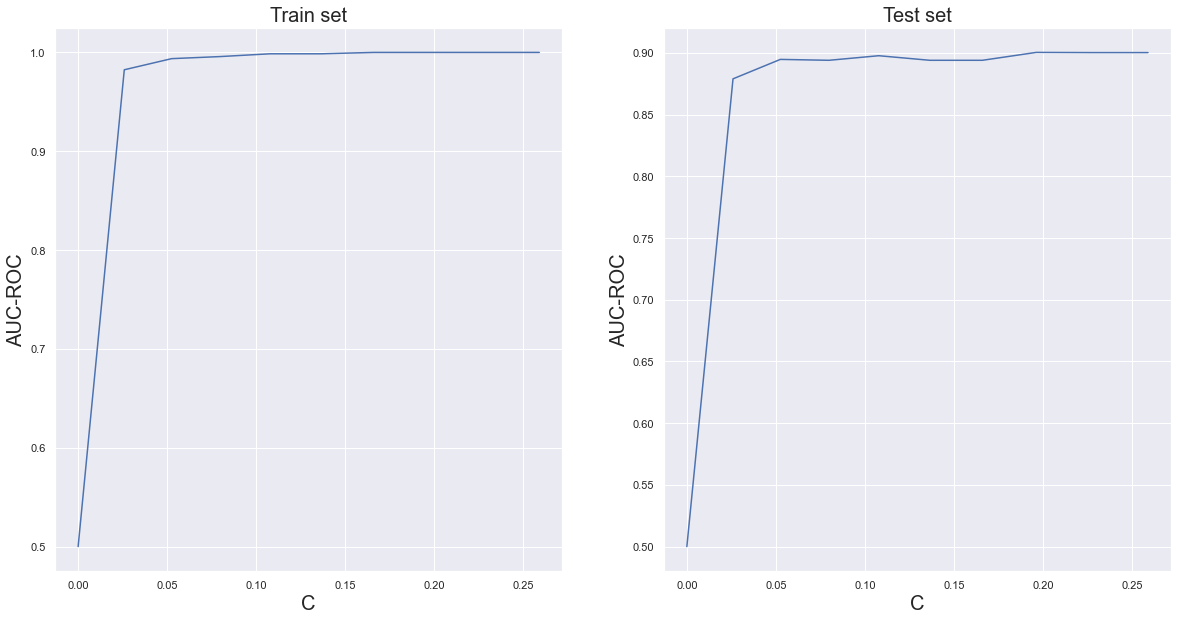

In [28]:
f, axes = plt.subplots(1,2, figsize=(20, 10))
axes[0].plot(c_list, c_AUC_perf_train)
axes[1].plot(c_list, c_AUC_perf_test)

axes[0].set_ylabel('AUC-ROC', size=20)
axes[0].set_xlabel('C', size=20)
axes[0].set_title('Train set', size=20)

axes[1].set_ylabel('AUC-ROC', size=20)
axes[1].set_xlabel('C', size=20)
axes[1].set_title('Test set', size=20)

In [29]:
c_list

array([2.30261160e-05, 2.59353635e-02, 5.25191347e-02, 7.97917376e-02,
       1.07771021e-01, 1.36475297e-01, 1.65923350e-01, 1.96134454e-01,
       2.27128379e-01, 2.58925412e-01])

# Performance of cleaned data for different forest depth
### Identify optimal depth of Random Forest (130)

In [25]:
v_train, v_test, fraud_train, fraud_test = train_test_split(v_data, fraud_data, test_size = 0.2, random_state = 0)

forest_perf_test = []

forest_perf_train = []

for i in range(1,180):
    rfc = RandomForestClassifier(max_depth=i, random_state=0)

    rfc.fit(v_train, fraud_train)
    pred_v_train = rfc.predict(v_train)
    forest_perf_train.append(roc_auc_score(fraud_train, pred_v_train))

    pred_v_test = rfc.predict(v_test)
    forest_perf_test.append(roc_auc_score(fraud_test, pred_v_test))

<ipython-input-25-aaec3d250f6c>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(v_train, fraud_train)
<ipython-input-25-aaec3d250f6c>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(v_train, fraud_train)
<ipython-input-25-aaec3d250f6c>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(v_train, fraud_train)
<ipython-input-25-aaec3d250f6c>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(v_train, fraud_train)
<ipython-input-25-aaec3d250f6c>:10: DataConversionWarning: A column-vector y was passed when a 1d array was 

<ipython-input-25-aaec3d250f6c>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(v_train, fraud_train)
<ipython-input-25-aaec3d250f6c>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(v_train, fraud_train)
<ipython-input-25-aaec3d250f6c>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(v_train, fraud_train)
<ipython-input-25-aaec3d250f6c>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(v_train, fraud_train)
<ipython-input-25-aaec3d250f6c>:10: DataConversionWarning: A column-vector y was passed when a 1d array was 

<ipython-input-25-aaec3d250f6c>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(v_train, fraud_train)
<ipython-input-25-aaec3d250f6c>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(v_train, fraud_train)
<ipython-input-25-aaec3d250f6c>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(v_train, fraud_train)
<ipython-input-25-aaec3d250f6c>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(v_train, fraud_train)
<ipython-input-25-aaec3d250f6c>:10: DataConversionWarning: A column-vector y was passed when a 1d array was 

<ipython-input-25-aaec3d250f6c>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(v_train, fraud_train)
<ipython-input-25-aaec3d250f6c>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(v_train, fraud_train)
<ipython-input-25-aaec3d250f6c>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(v_train, fraud_train)
<ipython-input-25-aaec3d250f6c>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(v_train, fraud_train)
<ipython-input-25-aaec3d250f6c>:10: DataConversionWarning: A column-vector y was passed when a 1d array was 

<ipython-input-25-aaec3d250f6c>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(v_train, fraud_train)
<ipython-input-25-aaec3d250f6c>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(v_train, fraud_train)
<ipython-input-25-aaec3d250f6c>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(v_train, fraud_train)
<ipython-input-25-aaec3d250f6c>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(v_train, fraud_train)
<ipython-input-25-aaec3d250f6c>:10: DataConversionWarning: A column-vector y was passed when a 1d array was 

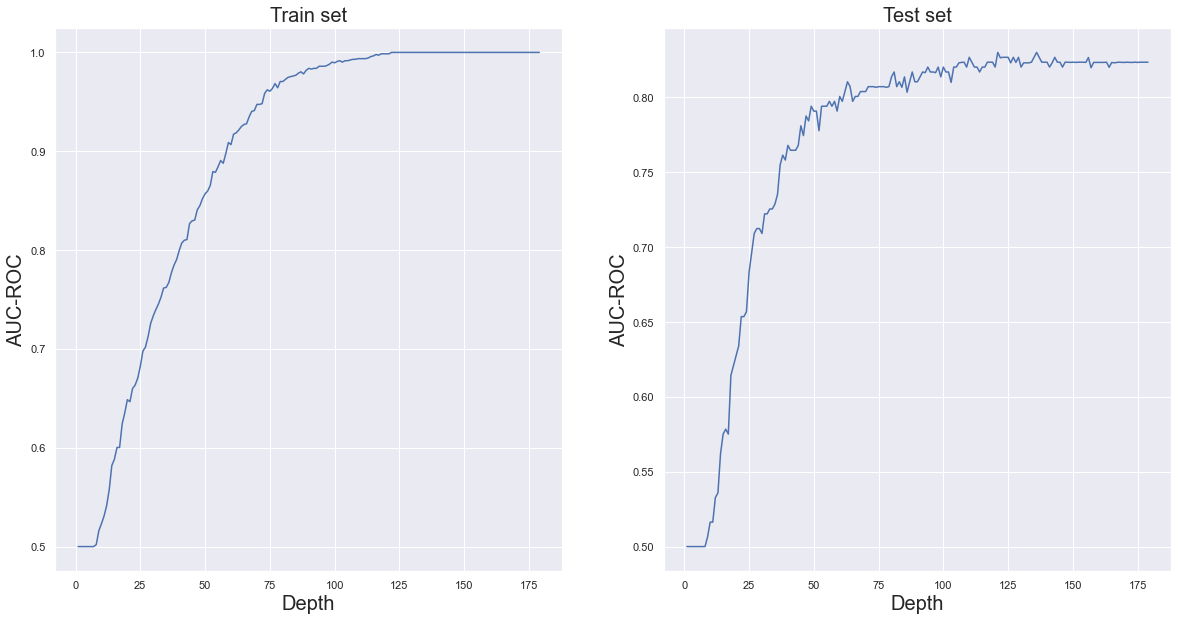

In [86]:
f, axes = plt.subplots(1,2, figsize=(20, 10))
axes[0].plot(range(1,180), forest_perf_train)

axes[1].plot(range(1,180), forest_perf_test)

axes[0].set_ylabel('AUC-ROC', size=20)
axes[0].set_xlabel('Depth', size=20)
axes[0].set_title('Train set', size=20)

axes[1].set_ylabel('AUC-ROC', size=20)
axes[1].set_xlabel('Depth', size=20)
axes[1].set_title('Test set', size=20)


plt.show()

# Performance of cleaned data with exclusion of individual features
### Compare AUC-ROC score of data with individual excluded feature against AUC-ROC score generated from including all features to identify relative importance

Differentiating predictors of job postings (in order of priority):
- company_profile
- description
- state

Poor differentiating predictors of job postings:
- function
- industry
- required_education
- city
- title

Predictors that causes overfitting:
- benefits
- has_questions
- has_company_logo

In [84]:
fraud_data = pd.DataFrame(inv_posting["fraudulent"])
cv = CountVectorizer()
rfc = RandomForestClassifier(max_depth=130, random_state=0)
auc_scores_train = []
auc_scores_test = []

for i in combination_columns:
    inv_posting = default_posting.copy()
    inv_posting['combined_feature'] = " "
    for j in combination_columns:
        if j != i:
            inv_posting['combined_feature'] += " " + inv_posting[j]
    v_data = tv.fit_transform(inv_posting["combined_feature"])
    v_train, v_test, fraud_train, fraud_test = train_test_split(v_data, fraud_data, random_state = 0, test_size = 0.2)
    
    rfc.fit(v_train, fraud_train)
    pred_v_train = rfc.predict(v_train)
    auc_scores_train.append(roc_auc_score(fraud_train, pred_v_train)-default_auc_train)
    
    pred_v_test = rfc.predict(v_test)
    auc_scores_test.append(roc_auc_score(fraud_test, pred_v_test)-default_auc_test)

<ipython-input-84-6fcbf9215ef0>:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(v_train, fraud_train)
<ipython-input-84-6fcbf9215ef0>:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(v_train, fraud_train)
<ipython-input-84-6fcbf9215ef0>:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(v_train, fraud_train)
<ipython-input-84-6fcbf9215ef0>:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(v_train, fraud_train)
<ipython-input-84-6fcbf9215ef0>:16: DataConversionWarning: A column-vector y was passed when a 1d array was 

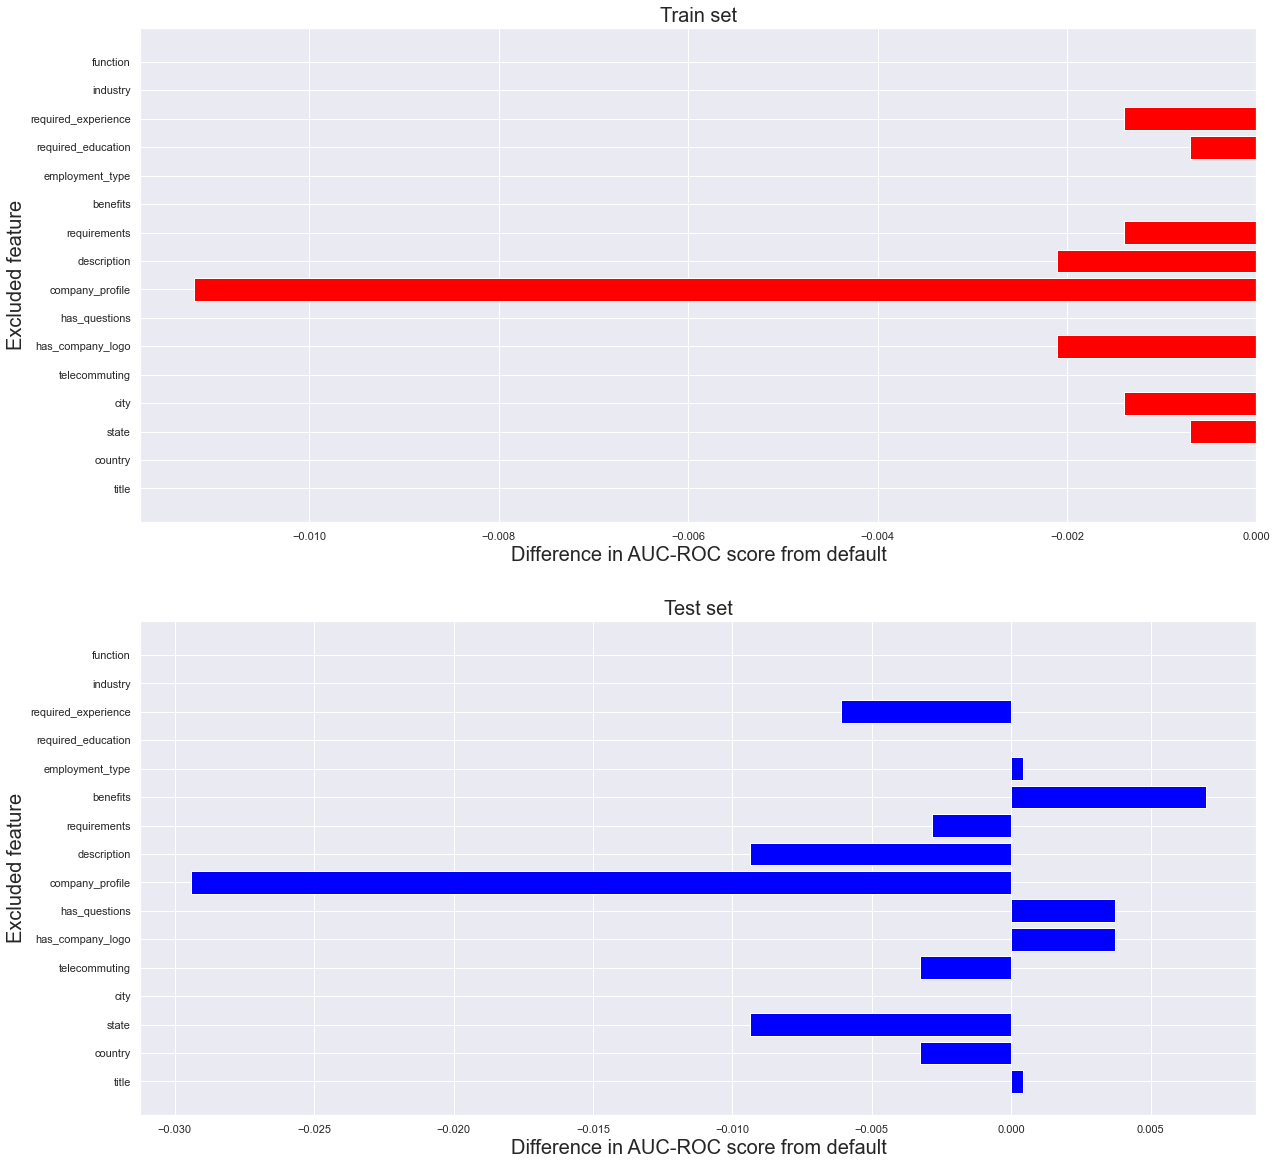

In [89]:
f, axes = plt.subplots(2,1, figsize=(20, 20))
axes[0].barh(combination_columns, width = auc_scores_train, orientation = 'horizontal', color='red')

axes[1].barh(combination_columns, width = auc_scores_test, orientation = 'horizontal', color='blue')

axes[0].set_ylabel('Excluded feature', size=20)
axes[0].set_xlabel('Difference in AUC-ROC score from default', size=20)
axes[0].set_title('Train set', size=20)

axes[1].set_ylabel('Excluded feature', size=20)
axes[1].set_xlabel('Difference in AUC-ROC score from default', size=20)
axes[1].set_title('Test set', size=20)

plt.show()